In [8]:
%matplotlib notebook
%load_ext autoreload
%pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [9]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 8.82 μs


In [11]:
# configuration settings
#data_root = '/ocean/projects/asc170022p/mtragoza/lung-project/data/Emory-4DCT'
data_root = '/ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/'
mask_roi = 'lung_regions2'
mesh_version = 11
num_levels = 3
num_conv_layers = 2
conv_channels = 32
conv_kernel_size = 3
output_func = 'relu'
rho_value = 0
interp_size = 5
interp_type = 'tent'
batch_size = 1
learning_rate = 1e-5
device = 'cpu'
save_every = 10
save_prefix = '2024-12-08_lung_regions2/asdf'
#save_prefix = f'2024-09-30__initial/train__batch_size__{mesh_radius}__{interp_radius}__{interp_sigma}__{output_func}__{batch_size}/'

In [12]:
project.utils.set_random_seed(667556723)

Setting random seed to 667556723


In [13]:
test_cases = project.imaging.ALL_CASES
train_phases = [p for p in project.imaging.ALL_PHASES if p != 0]
test_phases = [0]

train_cases = test_cases = ['Case7Pack']
train_phases = test_phases = [0]

print(test_cases)
print(test_phases)

train_images = project.imaging.Emory4DCT(data_root, train_cases, train_phases)
test_images = project.imaging.Emory4DCT(data_root, test_cases, test_phases)
train_images, test_images

['Case7Pack']
[0]


(Emory4DCT('/ocean/projects/asc170022p/shared/Data/4DLungCT/Emory', 1 cases),
 Emory4DCT('/ocean/projects/asc170022p/shared/Data/4DLungCT/Emory', 1 cases))

In [14]:
mask_roi2 = ['findings', 'consolidation', 'ggo']

train_images[0].load_niftis()
train_images[0].load_totalseg_masks(roi=mask_roi)
train_images[0].load_medpseg_masks(roi=mask_roi2)
print(train_images[0].medpseg_mask.sum())

test_images[0].load_niftis()
test_images[0].load_totalseg_masks(roi=mask_roi)
test_images[0].load_medpseg_masks(roi=mask_roi2)
test_images[0].load_displacements(moving_phase=10, relative=True)

print(test_images[0].medpseg_mask.sum())
print(test_images[0].medpseg_mask.max())

Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/NIFTI/case7_T00.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/TotalSegment/case7_T00/lung_regions2.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/medpseg/case7_T00_findings.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/medpseg/case7_T00_consolidation.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/medpseg/case7_T00_ggo.nii.gz
<xarray.DataArray 'mask' ()> Size: 8B
array(31740.)
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/NIFTI/case7_T00.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/TotalSegment/case7_T00/lung_regions2.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/medpseg/case7_T00_findings.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/medpseg/case7_T00_consolidatio

In [ ]:
mask = test_images[0].totalseg_mask.sel(roi=mask_roi)
mask.name = 'regions'

project.visual.XArrayViewer(
    mask, x='x', y='z'
).update_index(y=120, phase=0)

mask2 = test_images[0].medpseg_mask.sel(roi=mask_roi2)
mask2.name = 'regions'

project.visual.XArrayViewer(
    mask2, x='x', y='z'
).update_index(y=120, phase=0, roi=0)

project.visual.XArrayViewer(
    test_images[0].anat, x='x', y='z'
).update_index(y=120, phase=0)

project.visual.XArrayViewer(
    train_images[0].anat, x='x', y='z'
).update_index(y=120, phase=0)

disp = test_images[0].disp.sel(fixed_phase=0, moving_phase=10) * (test_images[0].totalseg_mask.sel(phase=0) > 0)
disp.name = 'displacement'

project.visual.XArrayViewer(
    disp, x='x', y='z'
)

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

shape = test_images[0].shape
resolution = test_images[0].resolution

coords = np.stack(
    np.meshgrid(
        np.arange(shape[0]) * resolution[0],
        np.arange(shape[1]) * resolution[1],
        np.arange(shape[2]) * resolution[2],
        indexing='xy'
    ),
    axis=-1
).reshape(-1, 3)

disp = test_images[0].disp.sel(fixed_phase=0, moving_phase=10).values.reshape(-1, 3)
mask = (test_images[0].totalseg_mask.sel(phase=0, roi=mask_roi) > 0).values.reshape(-1)

coords = coords[mask][::8,:]
disp = disp[mask][::8,:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(coords[:,1], coords[:,0], coords[:,2], disp[:,1], disp[:,0], disp[:,2])

In [15]:
train_examples = train_images.get_examples(mask_roi, mesh_version)
test_examples = test_images.get_examples(mask_roi, mesh_version)

len(train_examples), len(test_examples)

(1, 1)

In [16]:
train_data = project.data.Dataset(train_examples)
test_data = project.data.Dataset(test_examples)

In [17]:
model = project.model.UNet3D(
    in_channels=1,
    out_channels=1,
    num_levels=num_levels,
    num_conv_layers=num_conv_layers,
    conv_channels=conv_channels,
    conv_kernel_size=conv_kernel_size,
    output_func=output_func,
).to(device)

In [18]:
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    rho_value=rho_value,
    interp_size=interp_size,
    interp_type=interp_type,
    save_every=save_every,
    save_prefix=save_prefix
)

In [19]:
load_epoch = 0
if load_epoch > 0:
    trainer.load_state(epoch=load_epoch)

In [20]:
j, batch = trainer.get_next_batch(phase='train')
batch[-1]

Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/NIFTI/case7_T00.nii.gz... (256, 256, 94)
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/CorrField/case7_T10_T00.nii.gz... (256, 256, 94, 3)
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/TotalSegment/case7_T00/lung_regions2.nii.gz... (256, 256, 94)
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T00_lung_regions2_11.xdmf... 19624
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/medpseg/case7_T00_findings.nii.gz... (256, 256, 94)
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/medpseg/case7_T00_consolidation.nii.gz... (256, 256, 94)
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/medpseg/case7_T00_ggo.nii.gz... (256, 256, 94)


['case7_T00.nii']

In [ ]:
%autoreload
import torch

def check_nan(**kwargs):
    for k, v in kwargs.items():
        assert not torch.isnan(v).any(), f'{v} contains nan'

# manual forward pass
a_image, e_image, u_image, mask, disease_mask, resolution, pde, name = batch

check_nan(a_image=a_image, e_image=e_image, u_image=u_image, mask=mask, disease_mask=disease_mask)

a_image = a_image.to(device)
e_image = e_image.to(device)
u_image = u_image.to(device)
mask = (mask > 0).to(device)

e_pred_image = model.forward(a_image) * 1000
e_pred_image = e_pred_image.clamp(min=1, max=1e12)

points = pde[0].points.to(device)
radius = pde[0].radius.to(device)

a_dofs = project.interpolation.interpolate_image(
    a_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

rho_dofs = (a_dofs + 1000)

e_pred_dofs = project.interpolation.interpolate_image(
    e_pred_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

u_true_dofs = project.interpolation.interpolate_image(
    u_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

check_nan(u_true_dofs=u_true_dofs, e_pred_dofs=e_pred_dofs, rho_dofs=rho_dofs)

u_pred_dofs = pde[0].forward(
    u_true_dofs[None,:,:],
    e_pred_dofs[None,:,0],
    rho_dofs[None,:,0]
)[0]

check_nan(u_pred_dofs=u_pred_dofs)

u_pred_dofs.shape

In [ ]:
print(u_pred_dofs.numel())
print(u_pred_dofs.isnan().sum().item())

In [ ]:
e_pred_dofs[u_pred_dofs.isnan().any(dim=1)]

In [ ]:
# plot nans

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde[0].points.detach().cpu().numpy()
x = coords[:,0]
y = coords[:,1]
z = coords[:,2]

eps = 1e-6
values = u_pred_dofs.isnan().any(dim=-1).detach().cpu().numpy().astype(int)
normed = (values - values.min(axis=0)) / (values.max(axis=0) - values.min(axis=0) + eps)

c = normed * 1 + 0
s = normed * 5 + 1
a = normed * 0.9 + 0.1
print(c.shape, s.shape, a.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.scatter(x, y, z, c=c, cmap=project.visual.mre_color_map(symmetric=False), s=s, alpha=a)
ax.set_axis_off()

<IPython.core.display.Javascript object>


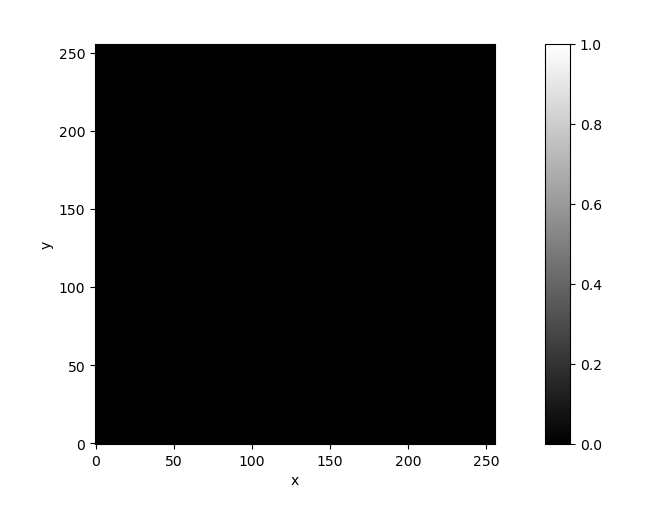

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [25]:
# view mask

project.visual.XArrayViewer(
    project.utils.as_xarray(mask[0,0], dims=['x', 'y', 'z'], name='mask')
)

In [26]:
# plot dofs

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde.points.detach().cpu().numpy()
disp = u_pred_dofs.detach().cpu().numpy() * 25

x = coords[:,0]
y = coords[:,1]
z = coords[:,2]
u_x = disp[:,0]
u_y = disp[:,1]
u_z = disp[:,2]

c = (disp - disp.min(axis=0)) / (disp.max(axis=0) - disp.min(axis=0))
print(c)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.quiver(x, y, z, u_x, u_y, u_z, colors=c, arrow_length_ratio=0.5)
ax.set_axis_off()

AttributeError: 'list' object has no attribute 'points'

In [ ]:
# plot dofs

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde.points.detach().cpu().numpy()
elast = e_pred_dofs.detach().cpu().numpy()
print(elast.min())
log_e = np.log10(elast)
print(log_e)
print(log_e.min(axis=0))

x = coords[:,0]
y = coords[:,1]
z = coords[:,2]

c = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0))
s = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0)) * 50 + 5
a = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0)) / 2
print(c)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.scatter(x, y, z, c=c, cmap=project.visual.mre_color_map(symmetric=False), s=s, alpha=a)
ax.set_axis_off()

In [ ]:
%%time
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=trainer.epoch)

In [ ]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [ ]:
%%time
trainer.timer.start()
trainer.train(num_epochs=250)

In [ ]:
trainer.evaluator.metrics

In [ ]:
trainer.timer.usage

In [ ]:
trainer.timer.usage.groupby(['phase', 'event']).mean().sort_values('time')

In [ ]:
trainer.timer.usage.reset_index()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

t = trainer.timer.usage.reset_index()

fig, ax = plt.subplots()
sns.lineplot(t[t.phase == 'train'], y='mem_used', x='batch')
fig.tight_layout()

In [ ]:


fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
test_data[0][-5].mean()

In [ ]:
%pwd